In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, to_dense_adj, convert
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader, DenseDataLoader
from torch_geometric.nn import GNNExplainer, GCNConv
from torch_geometric.nn import global_mean_pool, GlobalAttention

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import tree, linear_model

import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

np.random.seed(3)
torch.manual_seed(3)

In [2]:
# Learned from: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharingand 
    
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        
        num_hidden_units = 64 
        self.conv0 = GCNConv(num_node_features, num_hidden_units)
        self.conv1 = GCNConv(num_hidden_units, num_hidden_units)
        self.conv2 = GCNConv(num_hidden_units, num_hidden_units)
        
        self.pool0 = GlobalAttention(Linear(num_hidden_units, 1))
        self.pool1 = GlobalAttention(Linear(num_hidden_units, 1))
        self.pool2 = GlobalAttention(Linear(num_hidden_units, 1))
        
        self.lin = Linear(num_hidden_units, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv0(x, edge_index)
        x = x.relu()
        
        _ = self.pool0(x, batch) 
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        
        _ = self.pool1(x, batch)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        
        x = self.pool2(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    
global activation_list
activation_list = {}

def get_activation(idx):
    '''Learned from: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6'''
    def hook(model, input, output):
        activation_list[idx] = output.detach()

    return hook

def register_hooks(model):
    # register hooks to extract activations
    model.pool0.register_forward_hook(get_activation('pool0'))
    model.pool1.register_forward_hook(get_activation('pool1'))
    model.pool2.register_forward_hook(get_activation('pool2'))
    
    return model

In [3]:
def test(model, dataloader):
    # enter evaluation mode
    model.eval()

    correct = 0
    for data in dataloader:
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    
    return correct / len(dataloader.dataset)

def train(model, train_loader, test_loader, plot=False, save=False):
    # register hooks to track activation
    model.train()
    model = register_hooks(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # list of accuracies
    train_accuracies, test_accuracies, train_loss = list(), list(), list()
    
    max_num_epochs = 400
    for epoch in range(max_num_epochs):        
        for data in train_loader:        
            optimizer.zero_grad()
        
            out = model(data.x, data.edge_index, data.batch)
            
            # calculate loss
            loss = criterion(out, data.y)
            loss.backward()
            train_loss.append(loss.item())

#             torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

            optimizer.step()

        # get accuracy
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)

        ## add to list and print
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc), end = "\r")


    # plut accuracy graph
    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()
        
        plt.plot(train_loss, label="Train loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.show()
        
        
    for data in full_loader:        
        out = model(data.x, data.edge_index, data.batch)
        
    if save:
        torch.save(model.state_dict(), "models/mutagenicity_model.pkl")
        
        with open("models/mutagenicity_activation.txt", 'wb') as file:
            pickle.dump(activation_list, file)

In [4]:
def load_data():    
    graphs = TUDataset(root='../../data/TUDataset', name='Mutagenicity')
    
    return graphs

def preprocess_input_graphs(graphs):
    torch.manual_seed(0)
    graphs = graphs.shuffle()
    
    train_idx = int(len(graphs) * 0.8)
    train_set = graphs[:train_idx]
    test_set = graphs[train_idx:]
        
    train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
    full_loader = DataLoader(graphs, batch_size=len(graphs), shuffle=False)
    
    return train_loader, test_loader, full_loader

In [5]:
graphs = load_data()
train_loader, test_loader, full_loader = preprocess_input_graphs(graphs)

num_node_features = graphs.num_node_features
num_classes = graphs.num_classes
model = GCN(num_node_features, num_classes)

def weights_init(m):
    if isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
        torch.nn.init.uniform_(m.bias.data)

load_pretrained = True

if load_pretrained:
    model.load_state_dict(torch.load("models/mutagenicity_model.pkl"))
    model.eval()

    with open("models/mutagenicity_activation.txt", 'rb') as file:
        activation_list = pickle.loads(file.read())

else:
    model.apply(weights_init)
    train(model, train_loader, test_loader, plot=True, save=True)

# TSNE

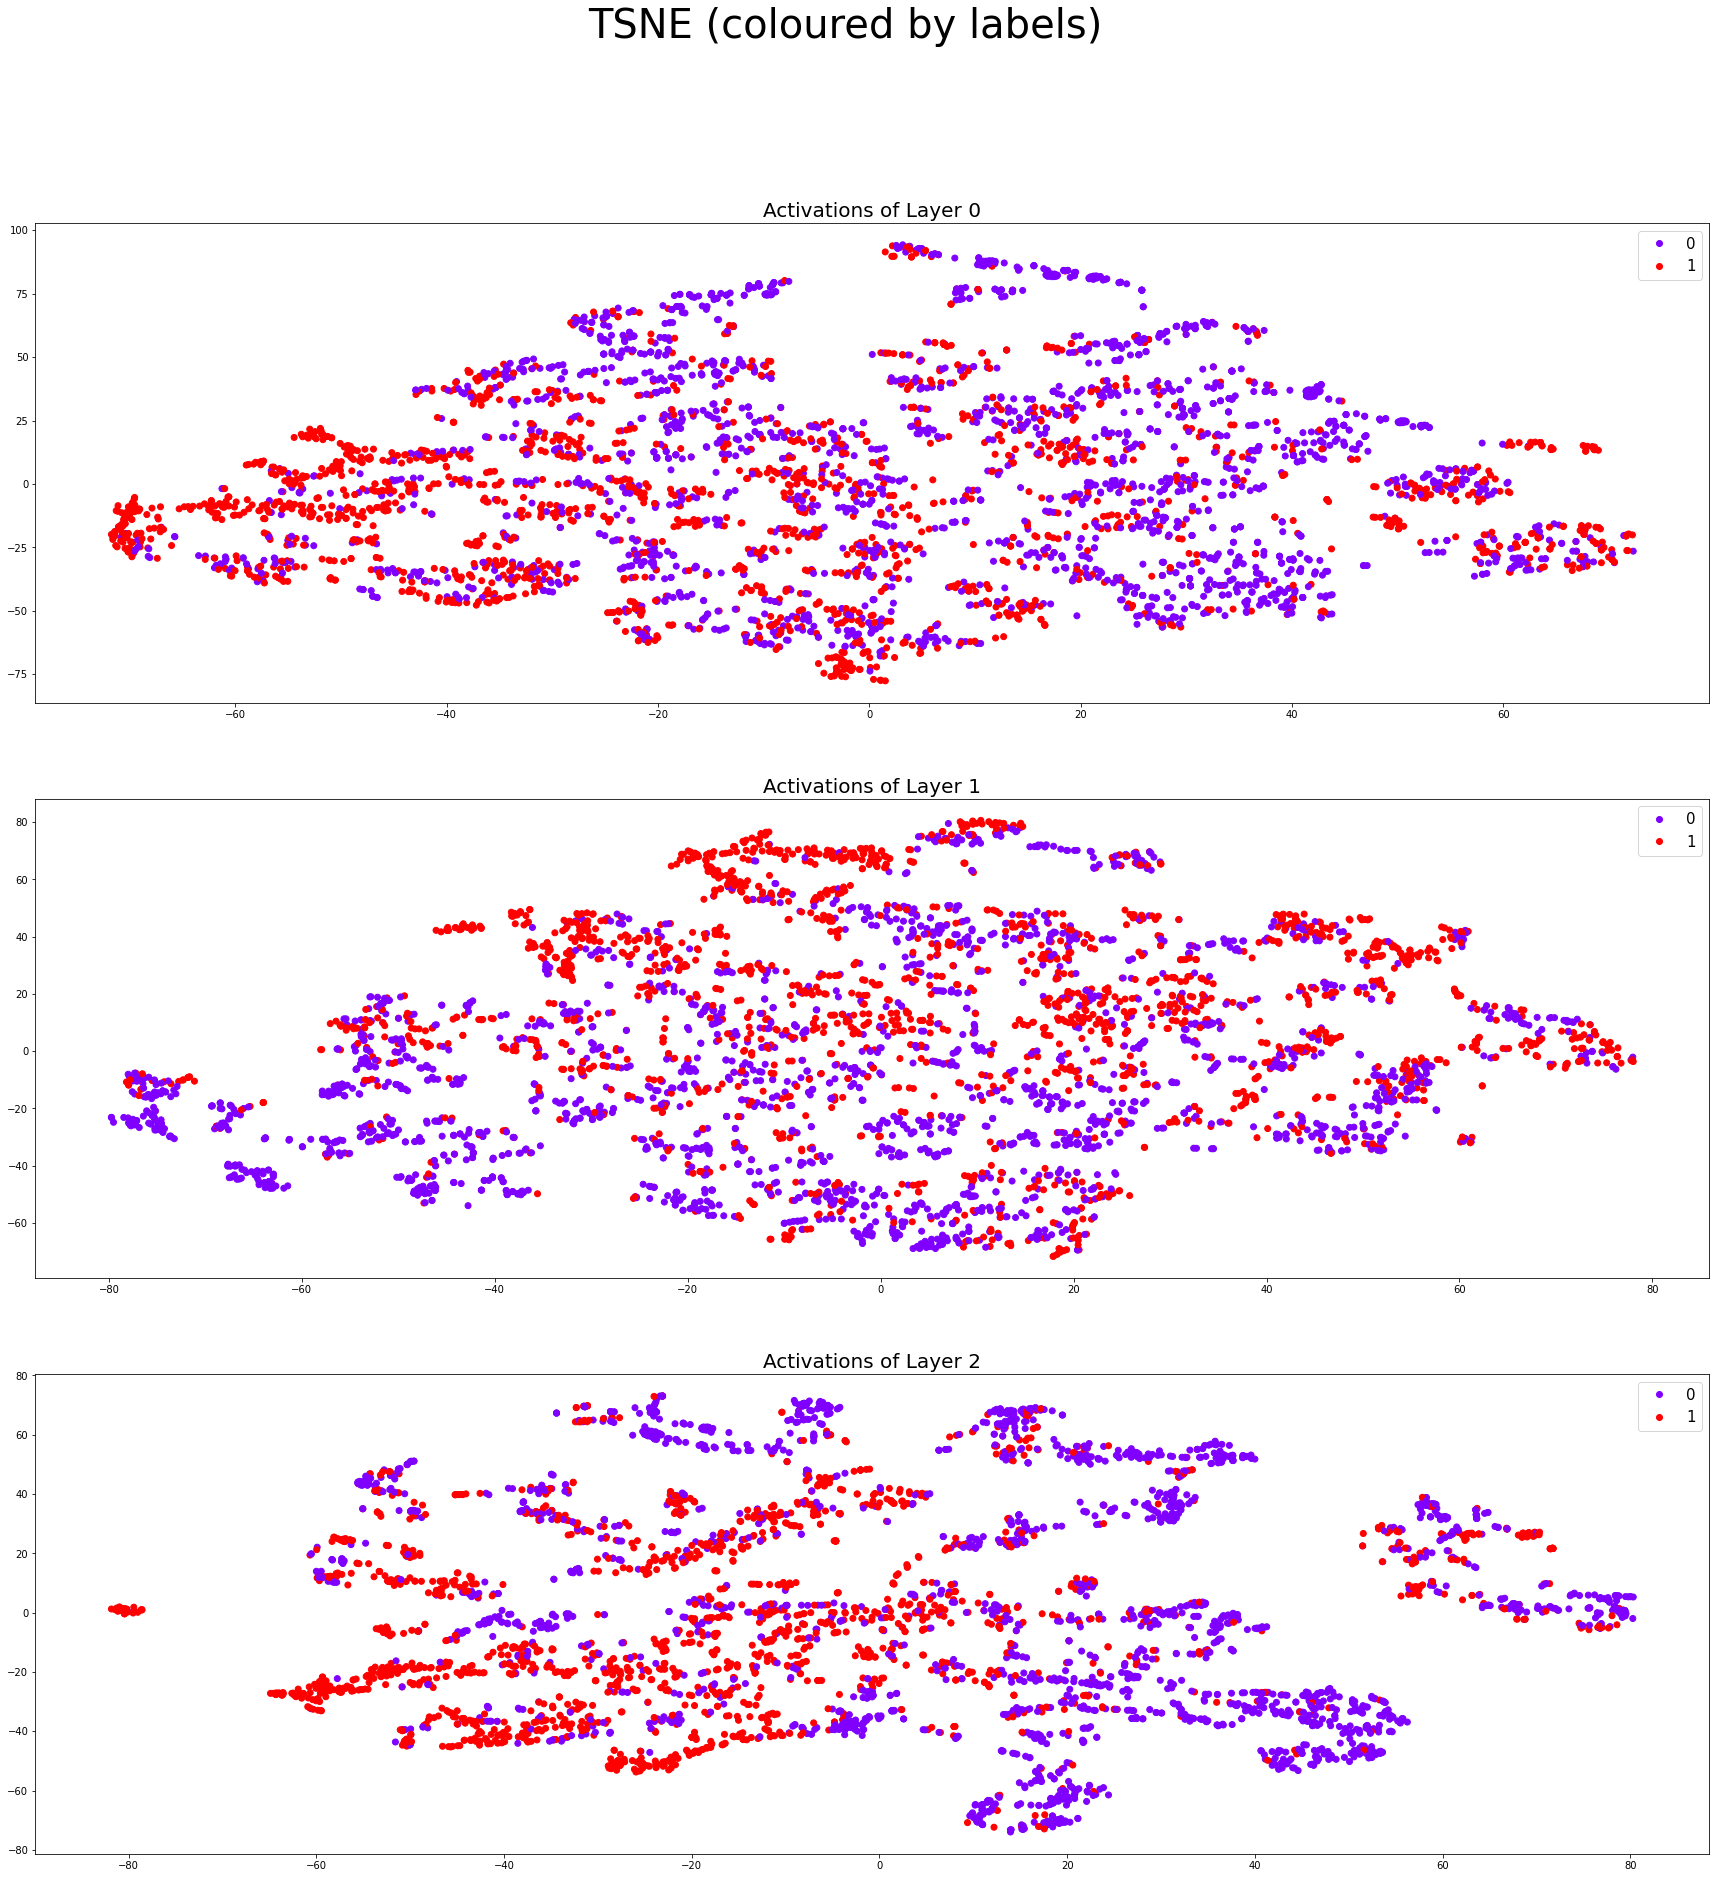

In [6]:
### Analysis
num_layers = len(activation_list)
labels = next(iter(full_loader)).y
k = 10

path = f"output/mutag/{k}Clusters"
os.makedirs(path, exist_ok=True)

def plot_activation_space(data, labels, activation_type):
    fig, axs = plt.subplots(num_layers, 1, figsize=(30, 30))
    fig.suptitle(f'{activation_type} (coloured by labels)', fontsize=40)

    counter = 0
    for ax in axs:
        item = data[counter]
        ax.set_title("Activations of Layer {}".format(counter), fontsize=20)
        scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
        ax.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(labels)), fontsize=15)
        counter += 1
        
    plt.savefig(os.path.join(path, "tsne.png"))
    plt.show()
            

# TSNE conversion
tsne_models = []
tsne_data = []
for key in activation_list:
    activation = torch.squeeze(activation_list[key]).detach().numpy()
    tsne_model = TSNE(n_components=2)
    tsne_models.append(tsne_model)
    tsne_data.append(tsne_model.fit_transform(activation))
    
# plot tsne graphs
plot_activation_space(tsne_data, labels, "TSNE")

# Perform KMeans Clustering

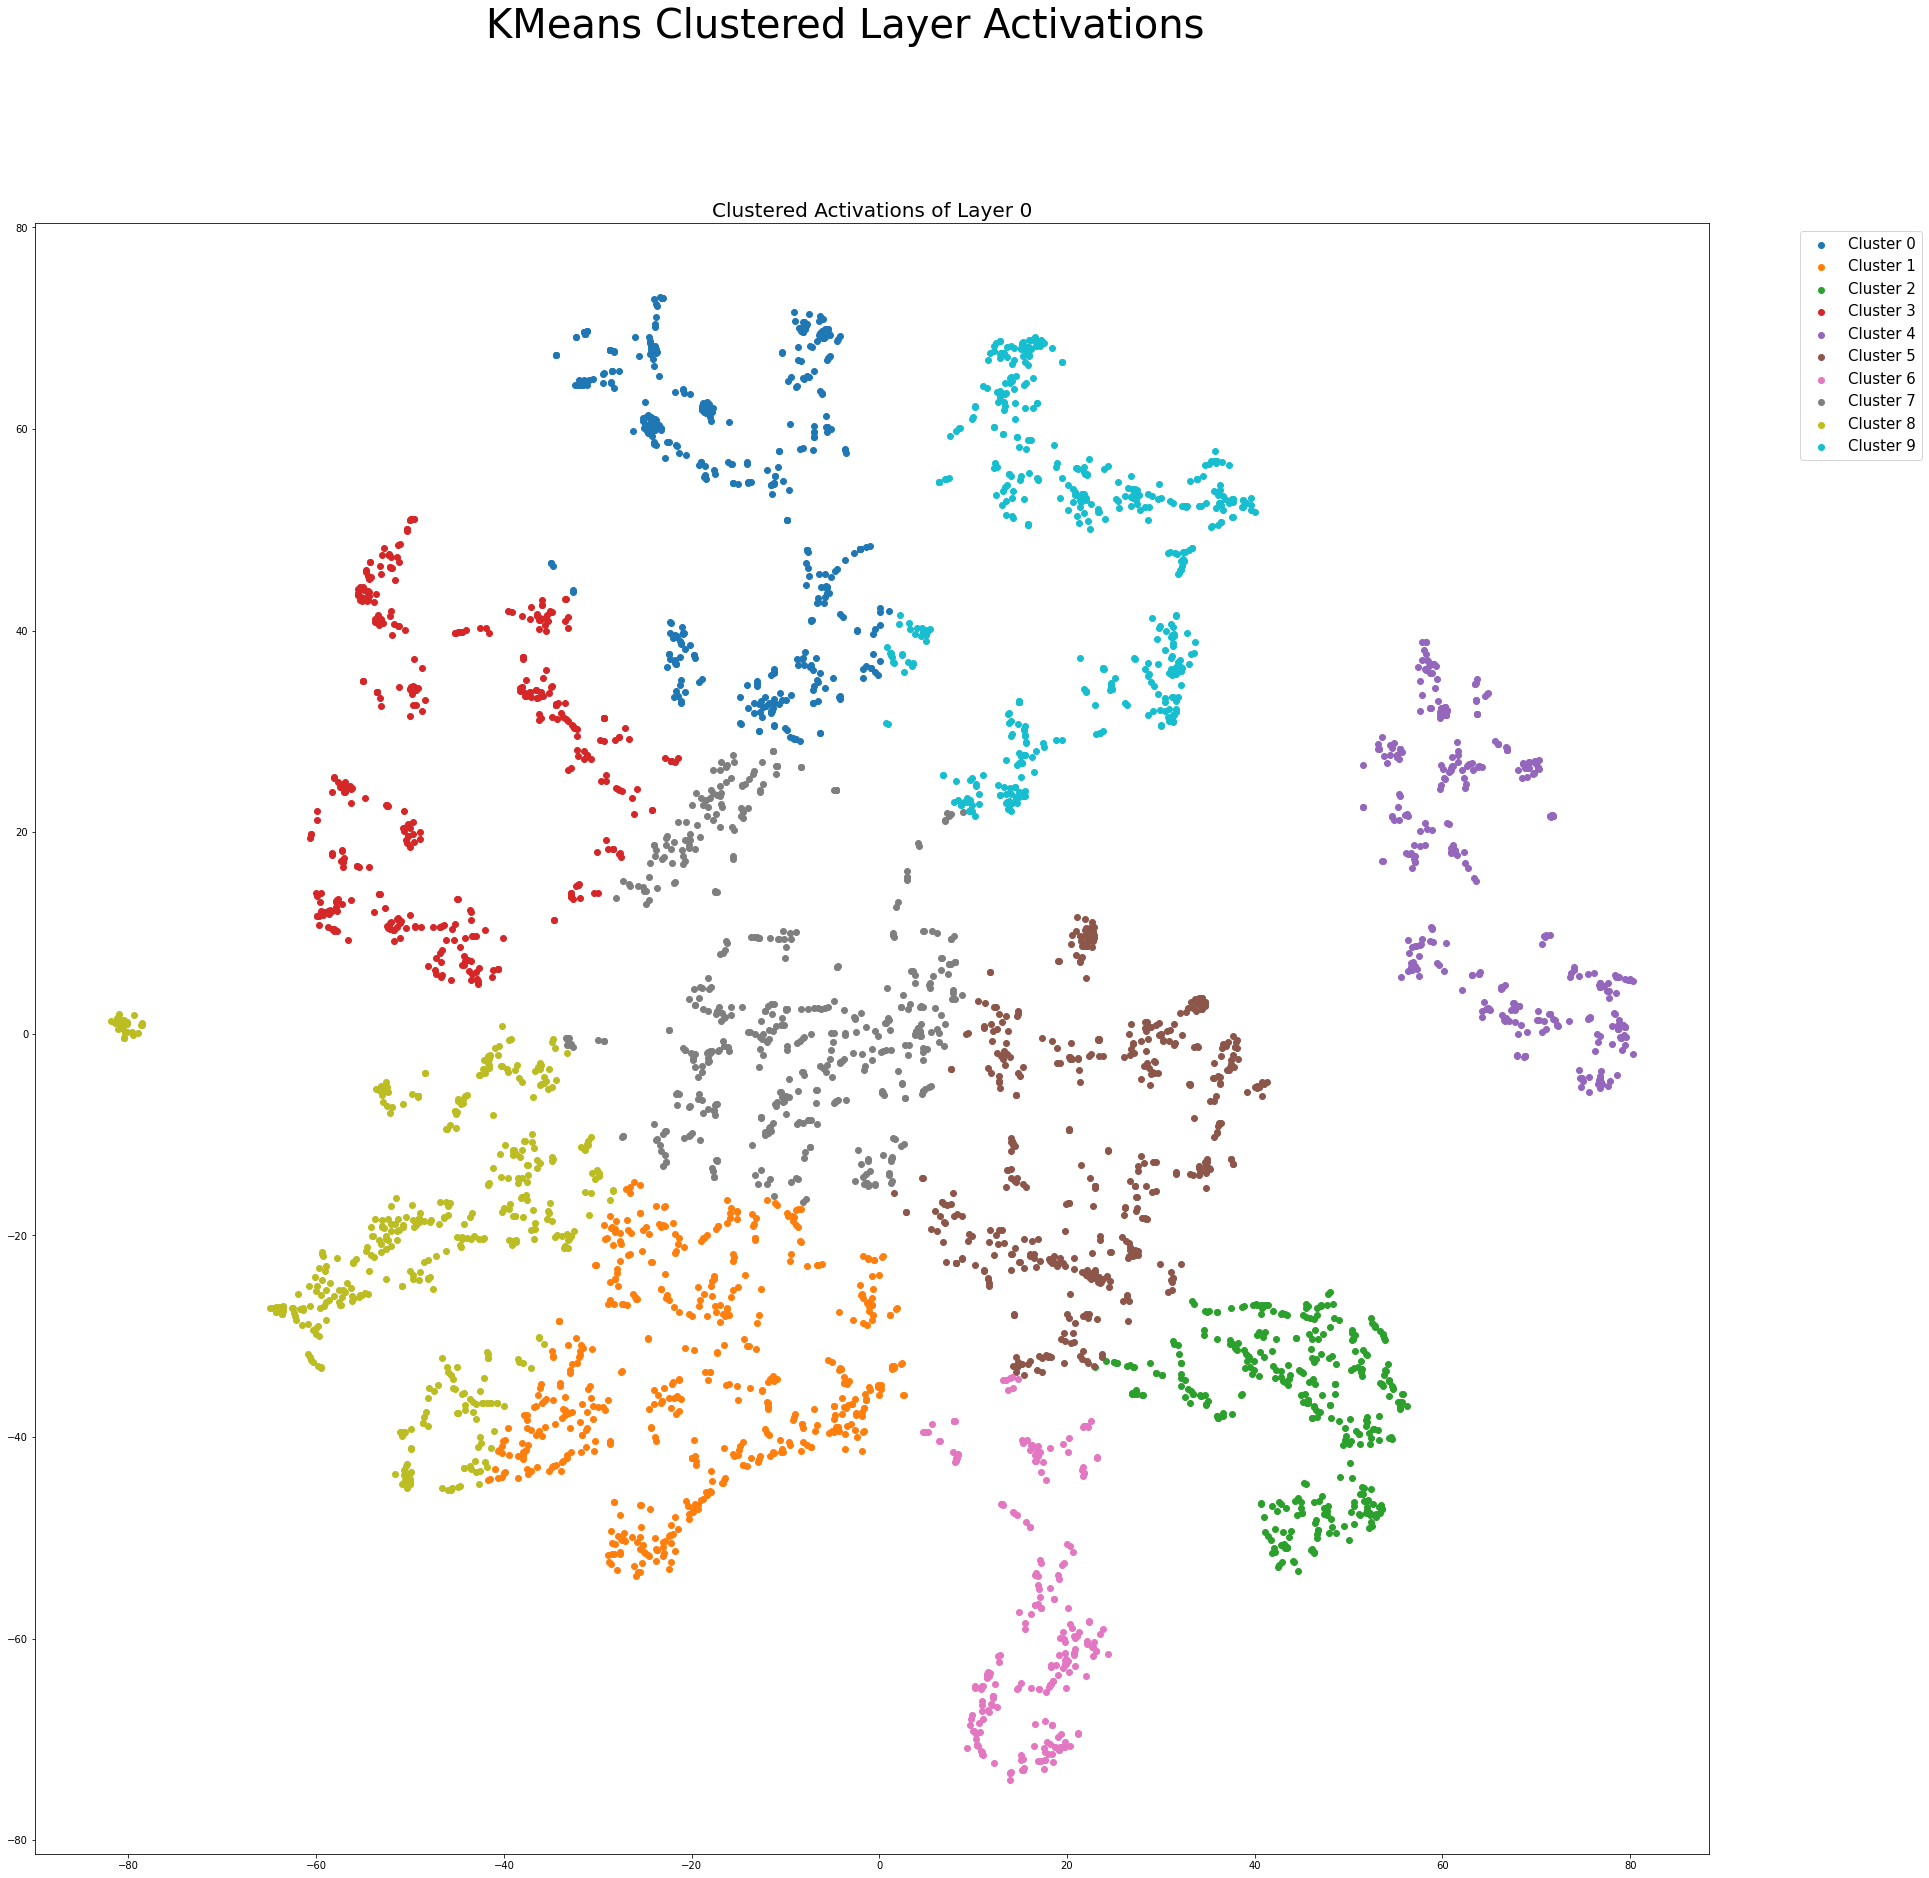

In [7]:
### Perform clustering

def plot_clusters(data, labels, clustering_type):
    rows = len(data)
    fig, axs = plt.subplots(rows, 1, figsize=(30, 30))
    fig.suptitle(f'{clustering_type} Clustered Layer Activations', fontsize=40)

    if rows == 1:
        axs = [axs]
    
    counter = 0
    for ax in axs:
        labels, item = data[counter]
        ax.set_title("Clustered Activations of Layer {}".format(counter), fontsize=20)
        
        for i in range(k):
            scatter = ax.scatter(item[labels == i,0], item[labels == i,1], label=f'Cluster {i}')
        
        ax.legend(fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left')
        counter += 1
        
    plt.savefig(os.path.join(path, f"{clustering_type}.png"))
    plt.show()

kmeans_models = []
kmeans_data = []
# for item in tsne_data:
#     kmeans_model = KMeans(n_clusters=k, random_state=0)
#     kmeans = kmeans_model.fit(item)
#     kmeans_models.append(kmeans_model)
#     kmeans_data.append((kmeans_model.predict(item), item))

item = tsne_data[2]
kmeans_model = KMeans(n_clusters=k, random_state=0)
kmeans = kmeans_model.fit(item)
kmeans_models.append(kmeans_model)
kmeans_data.append((kmeans_model.predict(item), item))

plot_clusters(kmeans_data, "KMeans")

In [38]:
# 1) get 3 closest nodes of a cluster
dataset_data = next(iter(full_loader))
edges = dataset_data.edge_index.transpose(0, 1).detach().numpy()

def get_top_graphs(graphs, top_indices):    
    top_graphs = []
    color_maps = []
    graph_labels = []
        
    for idx in top_indices:
        graph_data = graphs[int(idx)]
        new_G = nx.Graph()
        new_G.add_edges_from(graph_data.edge_index.transpose(0, 1).numpy())
        top_graphs.append(new_G)
        
        color_map = []
        for node, attribute in zip(new_G, graph_data.x.numpy()):
            color_idx = np.argmax(attribute, axis=0)
            color_map.append(color_idx)
            
        color_maps.append(color_map)
        
        graph_labels.append(graph_data.y)
            
    return top_graphs, color_maps, graph_labels


def calc_graph_similarity(top_graphs, num_nodes_view):
    top_G = top_graphs[0]
    
    if top_G.number_of_nodes() > 20:
        return "skipping (too many nodes)"
    
    total_score = 0
    for G in top_graphs[1:]:
        
        if G.number_of_nodes() > 20:
            return "skipping (too many nodes)"
        
#         too slow so going for optimised measure
#         total_score += nx.algorithms.similarity.graph_edit_distance(top_G, G)
        
        # optimised measure - get minimum
        min_val = float("inf")
        for val in nx.optimize_graph_edit_distance(top_G, G):
            if val < min_val:
                min_val = val
                
        total_score += min_val
        
    return total_score / (len(top_graphs) - 1)


def plot_samples(graphs, clustering_model, layer, data, clustering_type, output):
    num_nodes_view = 5
    
    fig, axes = plt.subplots(k, num_nodes_view, figsize=(30,30))
    fig.suptitle(f'Nearest to {clustering_type} Centroid for Layer {layer}', fontsize=40)

    l = list(range(0, k))

    for i, ax_list in zip(l, axes):        
        # get top graphs
        distances = clustering_model.transform(data)[:, i]
        top_indices = np.argsort(distances)[::][:num_nodes_view]
        top_graphs, color_maps, graph_labels = get_top_graphs(graphs, top_indices)
        
        for ax, new_G, color_map, g_label in zip(ax_list, top_graphs, color_maps, graph_labels):
            nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)
            ax.set_title(f"label {g_label}", fontsize=14)
            
    plt.savefig(os.path.join(path, f"{output}.png"))
    plt.show()

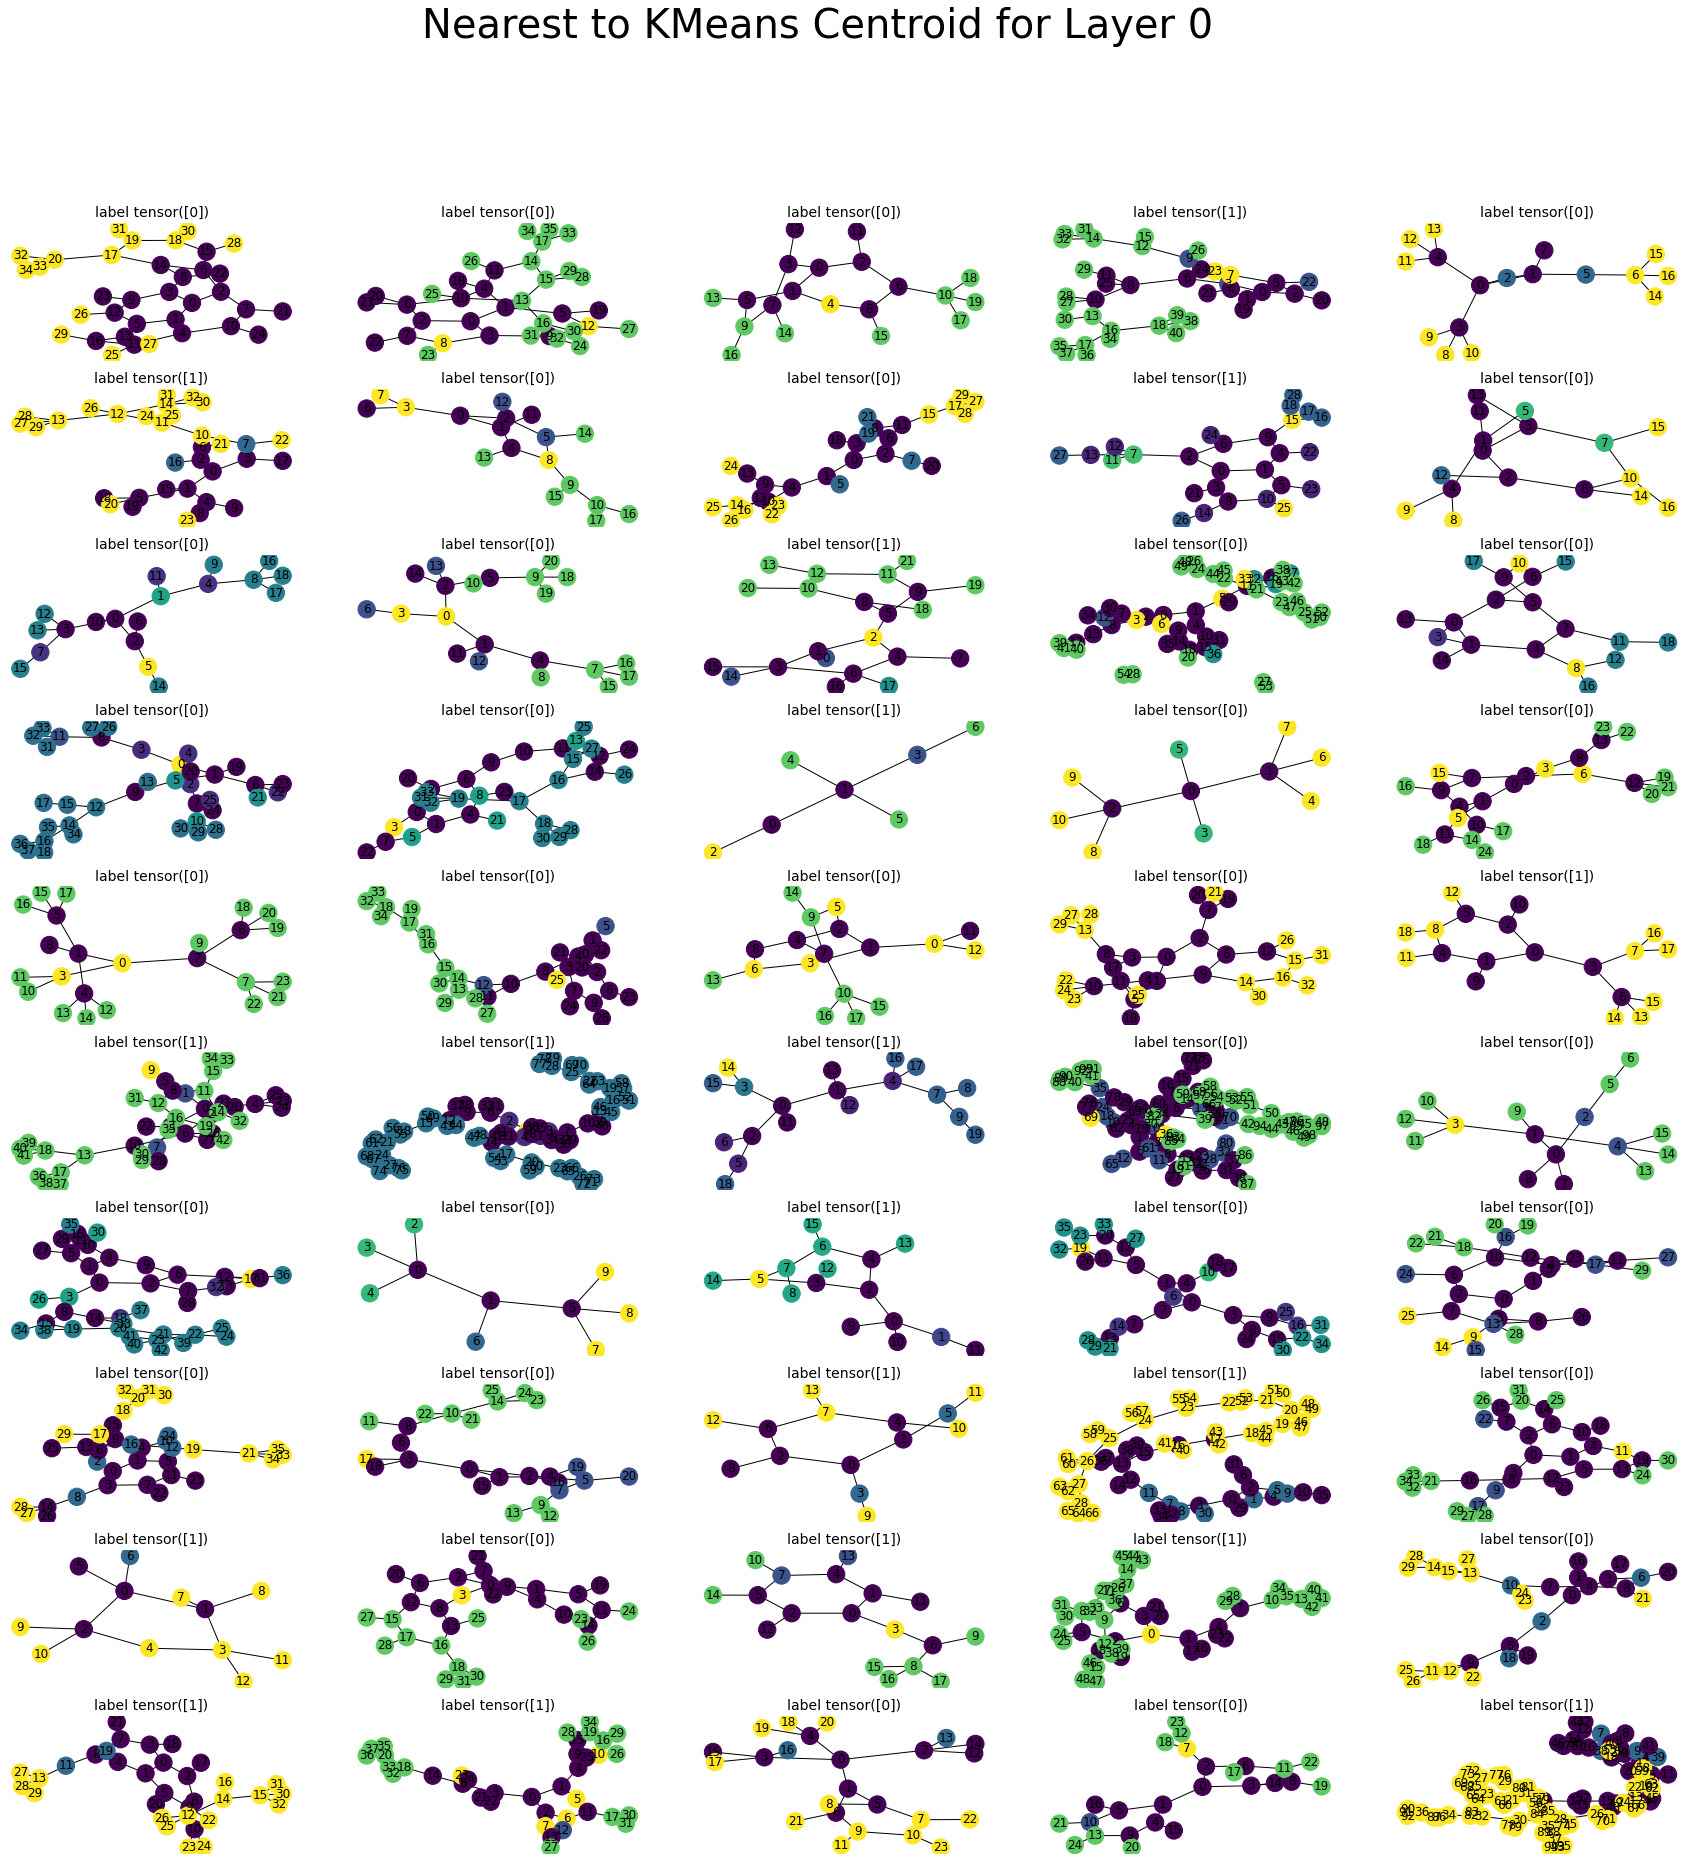

In [39]:
# for i in range(len(kmeans_models)):
#     kmeans_model = kmeans_models[i]
#     data = tsne_data[i]
#     plot_samples(kmeans_model, i, data, "KMeans", f"layer{i}")

i = 0
kmeans_model = kmeans_models[i]
data = tsne_data[i]
plot_samples(graphs, kmeans_model, i, data, "KMeans", f"layer{i}")

# Graph Similarity Score

In [40]:
# num_nodes_view = 5

# def print_graph_similarity_score(clustering_model, data, layer, max_k):
#     output = []
#     for k_idx in range(max_k):
#         top_graphs, color_maps = get_top_graphs(clustering_model, data, k_idx, num_nodes_view)
#         score = calc_graph_similarity(top_graphs, num_nodes_view)
#         string = f"Layer {layer} - Cluster {k_idx} - Avg Graph Similarity Score: {score}"
#         print(string)
#         output.append(string)
        
#     return output
        
        
# output_strs = []
# for layer_i, (clustering_model, data) in enumerate(zip(kmeans_models, tsne_data)):
#     output = print_graph_similarity_score(clustering_model, data, layer_i, k)
#     output_strs += output
    
# with open(os.path.join(path, f"graph_similarity_scores.txt"), 'a') as file:
#     for s in output_strs:
#         f.write(f'{s}\n')

# Perform Hierarchical Clustering

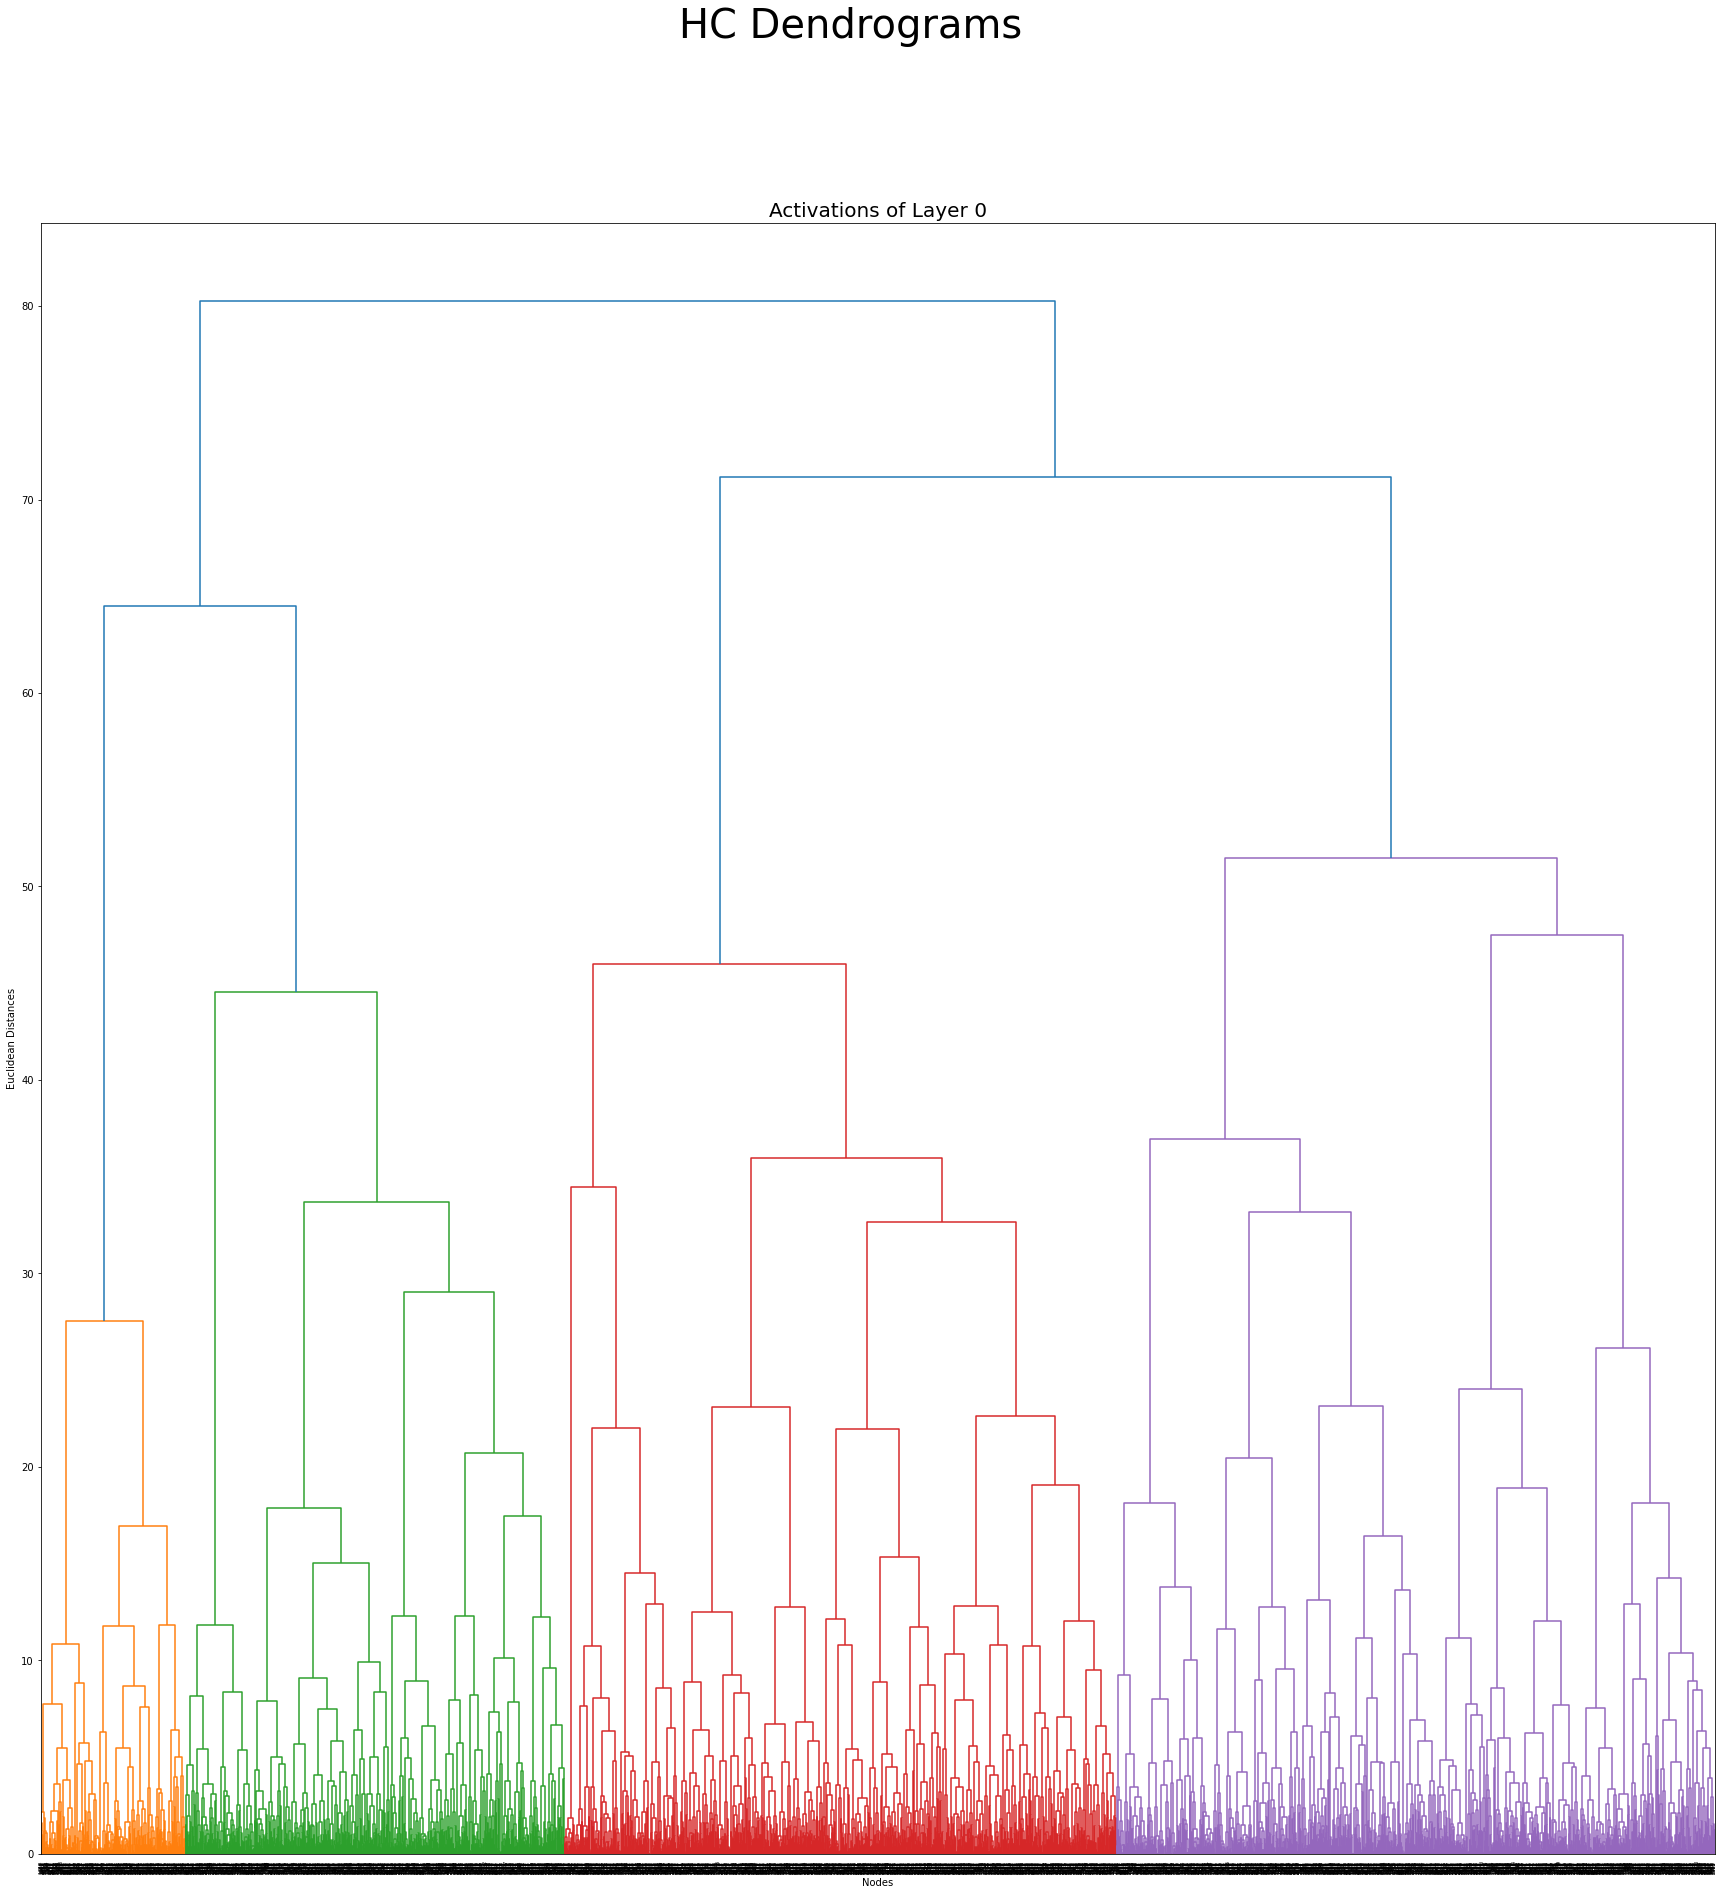

ValueError: Found array with dim 3. AgglomerativeClustering expected <= 2.

In [41]:
# Perform clustering
# Learned from: https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318


def plot_dendrograms(data):
    rows = len(data)
    fig, axs = plt.subplots(rows, 1, figsize=(30, 30))
    fig.suptitle(f'HC Dendrograms', fontsize=40)
    
    if rows == 1:
        axs = [axs]

    counter = 0
    for ax in axs:
        item = data[counter]
        ax.set_title("Activations of Layer {}".format(counter), fontsize=20)

        dendrogram = hierarchy.dendrogram(hierarchy.linkage(item, method='average'), ax=ax)
        ax.set_xlabel("Nodes")
        ax.set_ylabel("Euclidean Distances")
        counter += 1
        
    plt.savefig(os.path.join(path, f"hc_dendrograms.png"))
    plt.show()

    
def plot_hierarchical_clusters(data, n_clusters, clustering_type):
    rows = len(data)
    fig, axs = plt.subplots(rows, 1, figsize=(30, 30))
    fig.suptitle(f'HC Clustered Layer Activations', fontsize=40)

    counter = 0
    for ax in axs:
        labels, item = data[counter]
        ax.set_title(f"{clustering_type} Clustered Activations of Layer {counter}", fontsize=20)
        
        for i in range(n_clusters[counter]):
            scatter = ax.scatter(item[labels == i,0], item[labels == i,1], label=f'Cluster {i}')
        
        ax.legend(fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left')
        counter += 1
        
    plt.savefig(os.path.join(path, f"hc.png"))
    plt.show()

def plot_hierarchical_clustering_samples(x, y_predict, layer):
    clf = NearestCentroid()
    clf.fit(x, y_predict)
    centroids = clf.centroids_
    
    res = pairwise_distances(centroids, x)
    res_sorted = np.argsort(res, axis=-1)
    
    n = len(centroids)
    num_nodes_view = 5
    
    fig, axes = plt.subplots(n, num_nodes_view, figsize=(30,30))
    fig.suptitle(f'Nearest to hierarchical centroid for Layer {layer}', fontsize=40)
    
    l = list(range(0, n))
    
    for i, ax_list in zip(l, axes):
        distances = res_sorted[i]
        top_indices = distances[:num_nodes_view]
        top_graphs, color_maps = get_top_graphs(top_indices)
        
        for ax, new_G, color_map in zip(ax_list, top_graphs, color_maps):
            nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)

    plt.savefig(os.path.join(path, f"hc_samples_layer{layer}.png"))
    plt.show()
                    

reduced_data = [tsne_data[2]]
plot_dendrograms(reduced_data)

n_clusters = [12]

hc_models = []
hc_data = []
# for i, (item, n) in enumerate(zip(tsne_data, n_clusters)):
#     hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
#     y_hc = hc.fit_predict(item)
#     hc_models.append(hc)
#     hc_data.append((y_hc, item))
#     plot_hierarchical_clustering_samples(item, y_hc, i)

i = 2
item = tsne_data[i]
n = n_clusters[0]
hc = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='average')
y_hc = hc.fit_predict(item)
hc_models.append(hc)
hc_data.append((y_hc, item))
plot_hierarchical_clustering_samples(item, y_hc, i)

plot_hierarchical_clusters(hc_data, n_clusters, "HC")

# Activation to Concept to Class

In [ ]:
class ActivationClassifier:
    def __init__(self, tsne_data, clustering_model, classifier_type, x, y, edge_list, layer):
        self.tsne_data = tsne_data
        self.clustering_model = clustering_model
        self.classifier_type = classifier_type
        self.x = x.detach().numpy()
        self.y = y.detach().numpy()
        self.edge_list = edge_list
        self.layer = layer
        
        self.classifier, self.accuracy = self._train_classifier()
        
        
    def _train_classifier(self):
        concepts = []
        for node_idx in range(len(node_data_x)):
            concepts.append(self.activation_to_concept(node_idx))
          
        if self.classifier_type == 'decision_tree':
            classifier = tree.DecisionTreeClassifier()
            classifier = classifier.fit(concepts, self.y)
        elif self.classifier_type == 'linear_regression':
            classifier = linear_model.LinearRegression()
            classifier = classifier.fit(concepts, self.y)
        
        # decision tree accuracy
        accuracy = classifier.score(concepts, self.y)

        return classifier, accuracy
    
    
    def get_classifier_accuracy(self):
        return self.accuracy
    

    def _activation_to_cluster(self, node):
        # apply tsne
        if isinstance(self.clustering_model, KMeans):
            activation = tsne_data[self.layer][node]
            activation = activation.reshape((1, 2))
            cluster = self.clustering_model.predict(activation)
            
        elif isinstance(self.clustering_model, AgglomerativeClustering):
            cluster = np.array([y_hc[node]])

        return cluster

    
    def _cluster_to_concept(self, cluster):
        concept = cluster

        return concept


    def activation_to_concept(self, node):
        # get cluster for node
        cluster = self._activation_to_cluster(node)

        # return cluster number as substitute of concept
        concept = self._cluster_to_concept(cluster)

        return concept

    
    def concept_to_class(self, concept):
        concept = concept.reshape(1, -1)
        pred = self.classifier.predict(concept)

        return pred

### Prep

In [ ]:
# get data
# node_data_x = torch.from_numpy(features).float()
# node_data_y = torch.from_numpy(labels)
# edge_list = torch.from_numpy(edges).transpose(0, 1)

temp = next(iter(full_loader))

node_data_x = temp.x
node_data_y = temp.y
edge_list = temp.edge_index.transpose(0, 1)

### Using KMeans

In [ ]:
# vars
chosen_layer = len(activation_list) - 1
KmeansActivationCls = ActivationClassifier(tsne_data, kmeans_models[chosen_layer], 'decision_tree', node_data_x, node_data_y, edge_list, chosen_layer)

print("Decision Tree Accuracy: ", KmeansActivationCls.get_decision_tree_accuracy())

# activation to concept
node_idx = 224
concept = KmeansActivationCls.activation_to_concept(node_idx)
print("Predicted concept is: ", concept)

cls = KmeansActivationCls.concept_to_class(concept)
print("Predicted class is: ", cls ," where real one is: ", node_data_y[node_idx])

### Using Hierarchical Clustering

In [ ]:
# vars
chosen_layer = len(activation_list) - 1
HcActivationCls = ActivationClassifier(tsne_data, hc, node_data_x, node_data_y, edge_list, chosen_layer)

print("Decision Tree Accuracy: ", HcActivationCls.get_decision_tree_accuracy())

# activation to concept
node_idx = 224
concept = HcActivationCls.activation_to_concept(node_idx)
print("Predicted concept is: ", concept)

cls = HcActivationCls.concept_to_class(concept)
print("Predicted class is: ", cls ," where real one is: ", node_data_y[node_idx])

# GNNExplainer

In [ ]:
# from copy import copy
# from math import sqrt
# from typing import Optional

# import torch
# from tqdm import tqdm
# import networkx as nx
# from torch_geometric.nn import MessagePassing
# from torch_geometric.data import Data
# from torch_geometric.utils import k_hop_subgraph, to_networkx

# EPS = 1e-15

# class GNNExplainer2(torch.nn.Module):
#     r"""The GNN-Explainer model from the `"GNNExplainer: Generating
#     Explanations for Graph Neural Networks"
#     <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
#     structures and small subsets node features that play a crucial role in a
#     GNN’s node-predictions.

#     .. note::

#         For an example of using GNN-Explainer, see `examples/gnn_explainer.py
#         <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
#         gnn_explainer.py>`_.

#     Args:
#         model (torch.nn.Module): The GNN module to explain.
#         epochs (int, optional): The number of epochs to train.
#             (default: :obj:`100`)
#         lr (float, optional): The learning rate to apply.
#             (default: :obj:`0.01`)
#         num_hops (int, optional): The number of hops the :obj:`model` is
#             aggregating information from.
#             If set to :obj:`None`, will automatically try to detect this
#             information based on the number of
#             :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
#             layers inside :obj:`model`. (default: :obj:`None`)
#         return_type (str, optional): Denotes the type of output from
#             :obj:`model`. Valid inputs are :obj:`"log_prob"` (the model returns
#             the logarithm of probabilities), :obj:`"prob"` (the model returns
#             probabilities) and :obj:`"raw"` (the model returns raw scores).
#             (default: :obj:`"log_prob"`)
#         log (bool, optional): If set to :obj:`False`, will not log any learning
#             progress. (default: :obj:`True`)
#     """

#     coeffs = {
#         'edge_size': 0.005,
#         'edge_reduction': 'sum',
#         'node_feat_size': 1.0,
#         'node_feat_reduction': 'mean',
#         'edge_ent': 1.0,
#         'node_feat_ent': 0.1,
#     }

#     def __init__(self, model, epochs: int = 100, lr: float = 0.01,
#                  num_hops: Optional[int] = None, return_type: str = 'log_prob',
#                  log: bool = True):
#         super(GNNExplainer2, self).__init__()
#         assert return_type in ['log_prob', 'prob', 'raw']
#         self.model = model
#         self.epochs = epochs
#         self.lr = lr
#         self.__num_hops__ = num_hops
#         self.return_type = return_type
#         self.log = log

#     def __set_masks__(self, x, edge_index, init="normal"):
#         (N, F), E = x.size(), edge_index.size(1)

#         std = 0.1
#         self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

#         std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
#         self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 module.__explain__ = True
#                 module.__edge_mask__ = self.edge_mask

#     def __clear_masks__(self):
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 module.__explain__ = False
#                 module.__edge_mask__ = None
#         self.node_feat_masks = None
#         self.edge_mask = None

#     @property
#     def num_hops(self):
#         if self.__num_hops__ is not None:
#             return self.__num_hops__

#         k = 0
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 k += 1
#         return k

#     def __flow__(self):
#         for module in self.model.modules():
#             if isinstance(module, MessagePassing):
#                 return module.flow
#         return 'source_to_target'

#     def __subgraph__(self, node_idx, x, edge_index, **kwargs):
#         num_nodes, num_edges = x.size(0), edge_index.size(1)

#         subset, edge_index, mapping, edge_mask = k_hop_subgraph(
#             node_idx, self.num_hops, edge_index, relabel_nodes=True,
#             num_nodes=num_nodes, flow=self.__flow__())

#         x = x[subset]
#         for key, item in kwargs.items():
#             if torch.is_tensor(item) and item.size(0) == num_nodes:
#                 item = item[subset]
#             elif torch.is_tensor(item) and item.size(0) == num_edges:
#                 item = item[edge_mask]
#             kwargs[key] = item

#         return x, edge_index, mapping, edge_mask, kwargs

#     def __loss__(self, node_idx, log_logits, pred_label):
#         loss = -log_logits[node_idx, pred_label[node_idx]]

#         m = self.edge_mask.sigmoid()
#         edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
#         loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
#         ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
#         loss = loss + self.coeffs['edge_ent'] * ent.mean()

#         m = self.node_feat_mask.sigmoid()
#         node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
#         loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
#         ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
#         loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

#         return loss

#     def __to_log_prob__(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.log_softmax(dim=-1) if self.return_type == 'raw' else x
#         x = x.log() if self.return_type == 'prob' else x
#         return x

#     def explain_node(self, node_idx, x, edge_index, **kwargs):
#         r"""Learns and returns a node feature mask and an edge mask that play a
#         crucial role to explain the prediction made by the GNN for node
#         :attr:`node_idx`.

#         Args:
#             node_idx (int): The node to explain.
#             x (Tensor): The node feature matrix.
#             edge_index (LongTensor): The edge indices.
#             **kwargs (optional): Additional arguments passed to the GNN module.

#         :rtype: (:class:`Tensor`, :class:`Tensor`)
#         """

#         self.model.eval()
#         self.__clear_masks__()

#         num_edges = edge_index.size(1)

#         # Only operate on a k-hop subgraph around `node_idx`.
#         x, edge_index, mapping, hard_edge_mask, kwargs = self.__subgraph__(
#             node_idx, x, edge_index, **kwargs)

#         # Get the initial prediction.
#         with torch.no_grad():
#             out = self.model(x=x, edge_index=edge_index, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             pred_label = log_logits.argmax(dim=-1)

#         self.__set_masks__(x, edge_index)
#         self.to(x.device)

#         optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
#                                      lr=self.lr)

#         if self.log:  # pragma: no cover
#             pbar = tqdm(total=self.epochs)
#             pbar.set_description(f'Explain node {node_idx}')

#         for epoch in range(1, self.epochs + 1):
#             optimizer.zero_grad()
#             h = x * self.node_feat_mask.view(1, -1).sigmoid()
#             out = self.model(x=h, edge_index=edge_index, **kwargs)
#             log_logits = self.__to_log_prob__(out)
#             loss = self.__loss__(mapping, log_logits, pred_label)
#             loss.backward()
#             optimizer.step()

#             if self.log:  # pragma: no cover
#                 pbar.set_description(f'Explain node {node_idx}, loss {loss.item()}')
#                 pbar.update(1)
#                 pbar.refresh()

#         if self.log:  # pragma: no cover
#             pbar.close()

#         node_feat_mask = self.node_feat_mask.detach().sigmoid()
#         edge_mask = self.edge_mask.new_zeros(num_edges)
#         edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

#         self.__clear_masks__()

#         return node_feat_mask, edge_mask


#     def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
#                            threshold=None, **kwargs):
#         r"""Visualizes the subgraph around :attr:`node_idx` given an edge mask
#         :attr:`edge_mask`.

#         Args:
#             node_idx (int): The node id to explain.
#             edge_index (LongTensor): The edge indices.
#             edge_mask (Tensor): The edge mask.
#             y (Tensor, optional): The ground-truth node-prediction labels used
#                 as node colorings. (default: :obj:`None`)
#             threshold (float, optional): Sets a threshold for visualizing
#                 important edges. If set to :obj:`None`, will visualize all
#                 edges with transparancy indicating the importance of edges.
#                 (default: :obj:`None`)
#             **kwargs (optional): Additional arguments passed to
#                 :func:`nx.draw`.

#         :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
#         """
#         import matplotlib.pyplot as plt
#         assert edge_mask.size(0) == edge_index.size(1)

#         # Only operate on a k-hop subgraph around `node_idx`.
#         subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
#             node_idx, self.num_hops, edge_index, relabel_nodes=True,
#             num_nodes=None, flow=self.__flow__())

#         edge_mask = edge_mask[hard_edge_mask]

#         if threshold is not None:
#             print("threshold set to ", threshold)
#             print(torch.max(edge_mask))
#             print(edge_mask.shape)
#             edge_mask = (edge_mask >= threshold).to(torch.float)
#             print(torch.max(edge_mask))

#         if y is None:
#             y = torch.zeros(edge_index.max().item() + 1,
#                             device=edge_index.device)
#         else:
#             y = y[subset].to(torch.float) / y.max().item()

#         data = Data(edge_index=edge_index, att=edge_mask, y=y,
#                     num_nodes=y.size(0)).to('cpu')
#         G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
#         mapping = {k: i for k, i in enumerate(subset.tolist())}
#         G = nx.relabel_nodes(G, mapping)

#         node_kwargs = copy(kwargs)
#         node_kwargs['node_size'] = kwargs.get('node_size') or 800
#         node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

#         label_kwargs = copy(kwargs)
#         label_kwargs['font_size'] = kwargs.get('font_size') or 10

#         pos = nx.spring_layout(G)
#         ax = plt.gca()
#         for source, target, data in G.edges(data=True):
#             ax.annotate(
#                 '', xy=pos[target], xycoords='data', xytext=pos[source],
#                 textcoords='data', arrowprops=dict(
#                     arrowstyle="->",
#                     alpha=max(data['att'], 0.1),
#                     shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
#                     shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
#                     connectionstyle="arc3,rad=0.1",
#                 ))
#         nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
#         nx.draw_networkx_labels(G, pos, **label_kwargs)

#         return ax, G

In [ ]:
# node_idx = 572

# # convert to edge format
# edges = edge_list.transpose(0, 1).t().contiguous()

# explainer = GNNExplainer2(model, epochs=200, return_type='log_prob', log=True)
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, node_data_x, edges)

In [ ]:
# ax, G = explainer.visualize_subgraph(node_idx, edges, edge_mask, y=node_data_y, threshold=0.8)
# plt.show()